In [3]:
#1 Obtener y cargar los datos del archivo titanic.csv
import pandas as pd
data=pd.read_csv('/home/juan-pablo/Escritorio/Sist inteligente/datasets/tested.csv')
#Analizar los datos de las tablas
display(data.head())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


     PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex  SibSp  Parch              Ticket Embarked  
0      male      0      0              330911        Q

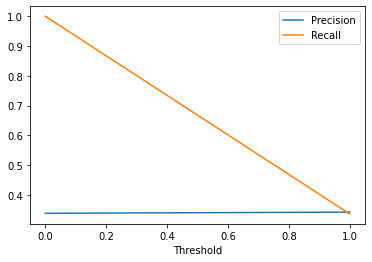

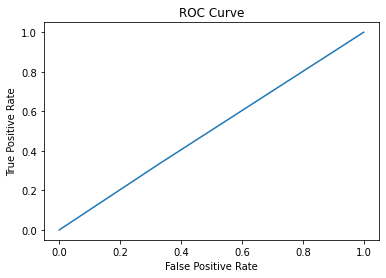

In [17]:
#La variable objetivo es la columna survived, que indica si el pasajero sobrevivió o no, con 1 o 0 respectivamente.
#al ser numerica es una variable continua, no debo transformarla, lo que voy a hacer es hacer una variable de clasificacion 
#despues separar los datos en train y test
#2 separar los datos en train y test
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, f1_score, auc

#En la variable de caracteristicas borro la columna survived
X=data.drop(['Survived'],axis=1)
Y=data['Survived']
# Supongamos que X es tu conjunto de datos
X = X.dropna(axis=1, thresh=len(X))  # elimina solo las columnas que tienen n o más valores faltantes

print(X)


# Supongamos que la columna 'Sex' contiene valores de cadena (string)
le = LabelEncoder()
X['Name'] = le.fit_transform(X['Name'])
X['Sex'] = le.fit_transform(X['Sex'])
X['Embarked'] = le.fit_transform(X['Embarked'])
X['Ticket'] = le.fit_transform(X['Ticket'])


#Separo en train y test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Creo una variable de clasificacion
y_train_1=(y_train==1)
y_test_1=(y_test==1)



#4 Limpiar y preparar los datos


#5 Seleccionar y entrenar un modelo
sgd_clf=SGDClassifier(random_state=42)
model = RandomForestClassifier()
#Creo un pipeline
# Crear el pipeline, donde se escalarán los datos y se entrenará el modelo de SGD que es un modelo de clasificación binario
pipeline = make_pipeline(
    StandardScaler(),
    sgd_clf
) 



#Enjtrenar el modelo
X=pipeline.fit(x_train,y_train_1)

#Prediccion
y_test_pred=pipeline.predict(x_test)

#Mido la precision con accuracy score
accuracy=accuracy_score(y_test_1,y_test_pred)
print("Accuracy con accuracy score, mas impreciso que val cruzada: ",accuracy)

#6 implementar validacion cruzada para poder evaluar el modelo
crossValAccuracy=cross_val_score(pipeline,x_train,y_train_1,cv=3,scoring='accuracy')
print("Accuracy cross value: ",crossValAccuracy)

#Me dio 100% de accuracy, pero no es muy confiable, creo que me puede dar overfitting, por eso voy a ajustar los parametros
#uso gridsearch

#defino los hiperparametros
param_grid={
    'alpha': [0.001, 0.01, 0.1, 1],
    'max_iter': [1000, 5000],
    'tol': [0.0001, 0.001]
}

#Defino la funcion de busqueda en cuadricula
grid_search=GridSearchCV(sgd_clf,param_grid,cv=3,scoring='accuracy',return_train_score=True)

#Entreno el modelo con la funcion de busqueda en cuadricula
grid_search.fit(x_train,y_train_1)

#Encontrar los mejores parametros
best_params = grid_search.best_params_
print("Los mejores hiperparámetros son:", best_params)

#Re entreno el modelo con los mejores hiperparametros el ** desempaqueto el diccionario de parametreos
best_model = SGDClassifier(**best_params, random_state=42)
best_pipeline = make_pipeline(
    StandardScaler(),
    best_model
)
best_pipeline.fit(x_train, y_train_1)
accuracy=cross_val_score(best_pipeline,x_train,y_train_1,cv=3,scoring='accuracy')
print("Accuracy cross value con los mejores parametros: ",accuracy)

#6.1 DummyClassifier
from sklearn.dummy import DummyClassifier

Most_Survived_Frecuent=DummyClassifier(strategy='most_frequent')
accuracy_cross_value=cross_val_score(Most_Survived_Frecuent,x_train,y_train_1,cv=3,scoring='accuracy')
print("Accuracy cross value most frequent: ",accuracy_cross_value)

#6.4 Implementar la matriz de confusion
y_pred=cross_val_predict(sgd_clf,x_train,y_train_1,cv=3)
matrix=confusion_matrix(y_train_1,y_pred)
print("Matriz de confusion: ",matrix)


#6.5 Implementar Precision (cuantas veces mi modelo **dice** es realmente cierto)
precision=precision_score(y_train_1,y_pred)
print("Precision: ",precision)
#6.6 Implementar Recall (cuantas veces mi modelo es capaz de 
#identificar la verdad)
recall=recall_score(y_train,y_pred)
print("Recall: ",recall)


#6.7 implementar f1 score (mezcla de precision y recall)
print("F1 score: ",f1_score(y_train,y_pred))



#6.8 implementar el TradeOff de recall y precision, apartir de los 

# Implementar el TradeOff de recall y precision, a partir de los umbrales
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()


#6.9 Implementar la curva de Roc


# Calcular la tasa de falsos positivos (fpr), tasa de verdaderos positivos (tpr) y umbrales para la curva ROC
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



#6.10 Comparar dos modelos con curva roc
#print("Comparacion de dos modelos con curva roc: ",roc_auc_score(y_train_1,y_pred))
#6.11 Multiclase
#print("Multiclase: ",cross_val_score(sgd_clf,x_train,y_train,cv=3,scoring='accuracy'))
#6.12 Analizar el error con graficos (ver si se puede)
#print("Analizar el error con graficos: ",cross_val_predict(sgd_clf,x_train,y_train,cv=3))